Import libraries for image processing, visualization and file management

In [3]:
import os
import shutil
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image

Defines original and target directories for the data

In [10]:
original_normal_path = '../data/raw/NORMAL'
original_pneumonia_path = '../data/raw/PNEUMONIA'
new_path = "../data/processed"
normal_path = os.path.join(new_path, "NORMAL")
viral_path = os.path.join(new_path, "PNEUMONIA", "VIRAL")
bacteria_path = os.path.join(new_path, "PNEUMONIA", "BACTERIAL")

 Creates folders for classified images if they don't exist

In [5]:
os.makedirs(normal_path, exist_ok=True)
os.makedirs(viral_path, exist_ok=True)
os.makedirs(bacteria_path, exist_ok=True)

Copy and rename images from the NORMAL class

In [8]:
for root, dirs, files in os.walk(original_normal_path):
    for filename in files:
        if filename.endswith(('.jpeg', '.jpg', '.png')):
            source_path = os.path.join(root, filename)
            
            dest_path = os.path.join(normal_path, f"normal_{len(os.listdir(normal_path))}.jpeg")
            shutil.copy(source_path, dest_path)

Classify images as VIRAL or BACTERIAL using filename patterns

In [ ]:
for root, dirs, files in os.walk(original_pneumonia_path):
    for filename in files:
        if filename.endswith(('.jpeg', '.jpg', '.png')):
            source_path = os.path.join(root, filename)
            fname_lower = filename.lower()
            if 'virus' in fname_lower or 'viral' in fname_lower:
                dest_path = os.path.join(viral_path, f"viral_{len(os.listdir(viral_path))}.jpeg")
                shutil.copy(source_path, dest_path)
            elif 'bacteria' in fname_lower or 'bacterial' in fname_lower:
                    dest_path = os.path.join(bacteria_path, f"bacterial_{len(os.listdir(bacteria_path))}.jpeg")
                    shutil.copy(source_path, dest_path)


Split dataset into balanced train/val/test and resize all images

In [15]:
INPUT_PATH = "../data/processed"
OUTPUT_PATH = "../data/splitted"
IMG_SIZE = (224, 224)
SPLIT_RATIOS = {'train': 0.7, 'val': 0.15, 'test': 0.15}

CLASSES = {
    "NORMAL": os.path.join(INPUT_PATH, "NORMAL"),
    "PNEUMONIA/BACTERIAL": os.path.join(INPUT_PATH, "PNEUMONIA", "BACTERIAL"),
    "PNEUMONIA/VIRAL": os.path.join(INPUT_PATH, "PNEUMONIA", "VIRAL")
}

def prepare_directories():
    if os.path.exists(OUTPUT_PATH):
        shutil.rmtree(OUTPUT_PATH)
    for split in SPLIT_RATIOS:
        for clase_rel in CLASSES:
            dest_dir = os.path.join(OUTPUT_PATH, split, clase_rel)
            os.makedirs(dest_dir, exist_ok=True)

def process_and_save(src_path, dst_path):
    try:
        with Image.open(src_path) as img:
            img = img.convert("RGB")
            img = img.resize(IMG_SIZE)
            img.save(dst_path)
    except Exception as e:
        print(f"Processing error: {src_path}: {e}")

def split_and_save(clase_rel, src_dir):
    img_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(img_files)

    total = len(img_files)
    n_train = int(SPLIT_RATIOS['train'] * total)
    n_val = int(SPLIT_RATIOS['val'] * total)

    split_data = {
        'train': img_files[:n_train],
        'val': img_files[n_train:n_train + n_val],
        'test': img_files[n_train + n_val:]
    }

    for split, filenames in split_data.items():
        for i, fname in enumerate(filenames):
            src = os.path.join(src_dir, fname)
            new_name = f"{clase_rel.replace('/', '_')}_{i}.jpeg"
            dst = os.path.join(OUTPUT_PATH, split, clase_rel, new_name)
            process_and_save(src, dst)

def main():
    prepare_directories()
    for clase_rel, clase_path in CLASSES.items():
        print(f"Processing class: {clase_rel}")
        split_and_save(clase_rel, clase_path)
    print("Split and resize completed. Structure in 'splitted/'.")

if __name__ == "__main__":
    main()


Processing class: NORMAL
Processing class: PNEUMONIA/BACTERIAL
Processing class: PNEUMONIA/VIRAL
✅ Split and resize completed. Structure in 'splitted/'.


Define base paths to build metadata


In [4]:
base_dir = "../data/splitted"
splits = ['train', 'val', 'test']
categories = ['NORMAL', 'BACTERIAL', 'VIRAL']

In [5]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Builds metadata DataFrame with image stats

In [6]:
def collect_image_metadata():
    records = []
    for split in splits:
        for category in categories:
            folder = os.path.join(base_dir, split, category)
            if not os.path.exists(folder):
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpeg', '.jpg', '.png')):
                    fpath = os.path.join(folder, fname)
                    try:
                        with Image.open(fpath) as img:
                            width, height = img.size
                        records.append({
                            "split": split,
                            "label": category,
                            "filename": fname,
                            "width": width,
                            "height": height,
                            "path": fpath
                        })
                    except:
                        continue
    return pd.DataFrame(records)


In [7]:
df = collect_image_metadata()

Count images per label and split

In [8]:
print("Total images by class:")
print(df['label'].value_counts())

print("\nSplit and class distribution:")
print(df.groupby(['split', 'label']).size())

Total images by class:
label
BACTERIAL    2898
NORMAL       1583
VIRAL        1582
Name: count, dtype: int64

Split and class distribution:
split  label    
test   BACTERIAL     436
       NORMAL        238
       VIRAL         238
train  BACTERIAL    2028
       NORMAL       1108
       VIRAL        1107
val    BACTERIAL     434
       NORMAL        237
       VIRAL         237
dtype: int64


Bar plot: image count per class, Split distribution by class and Histogram of image areas

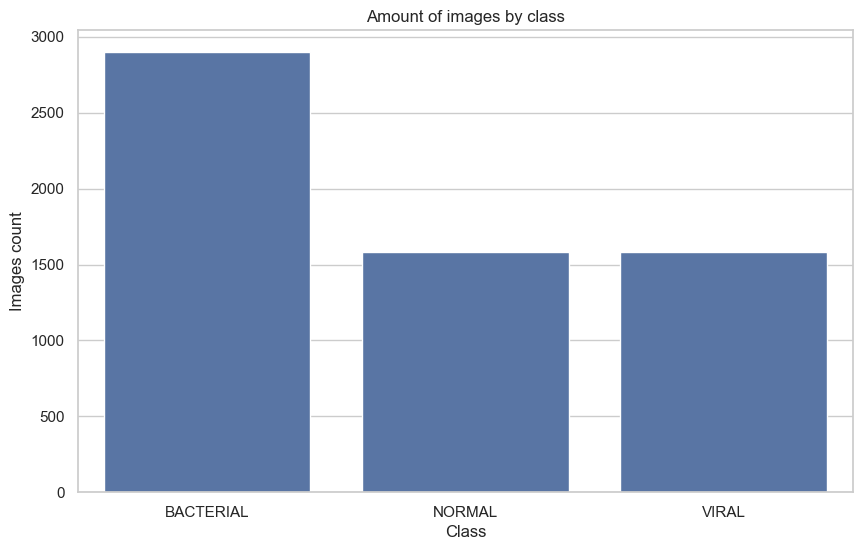

In [9]:
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Amount of images by class")
plt.xlabel("Class")
plt.ylabel("Images count")
plt.show()

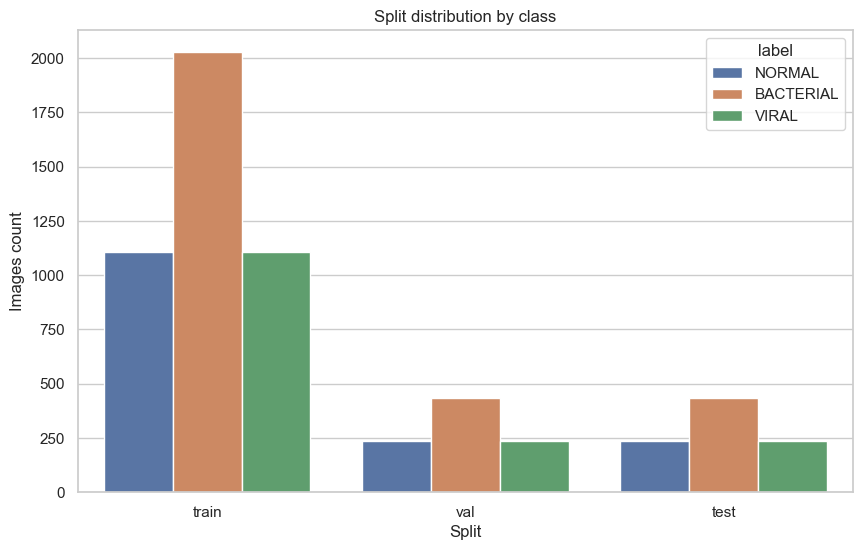

In [10]:
sns.countplot(data=df, x='split', hue='label')
plt.title("Split distribution by class")
plt.xlabel("Split")
plt.ylabel("Images count")
plt.show()

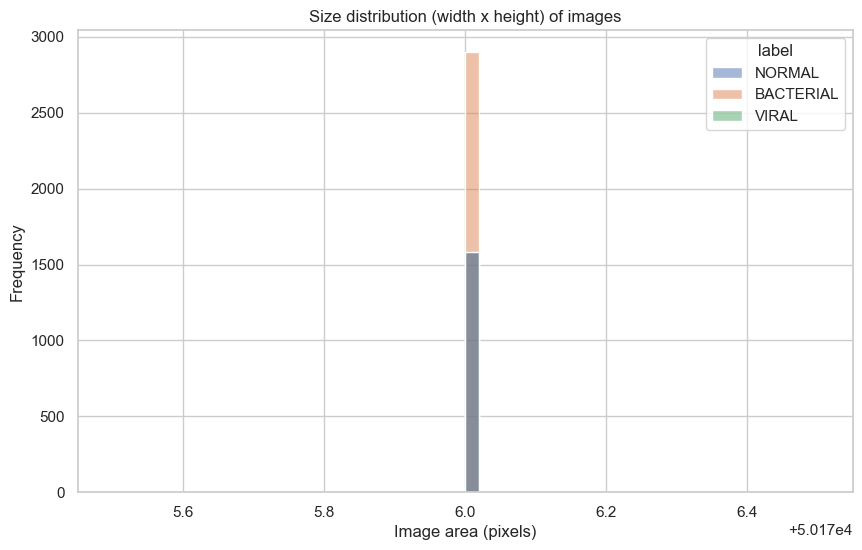

In [12]:
df['area'] = df['width'] * df['height']
sns.histplot(data=df, x='area', hue='label', bins=50, kde=True)
plt.title("Size distribution (width x height) of images")
plt.xlabel("Image area (pixels)")
plt.ylabel("Frequency")
plt.show()

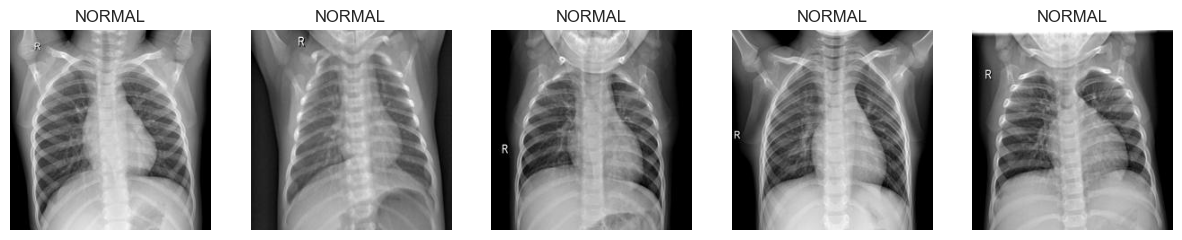

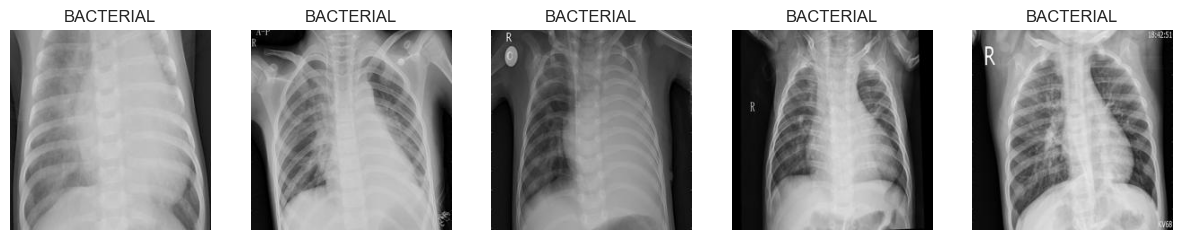

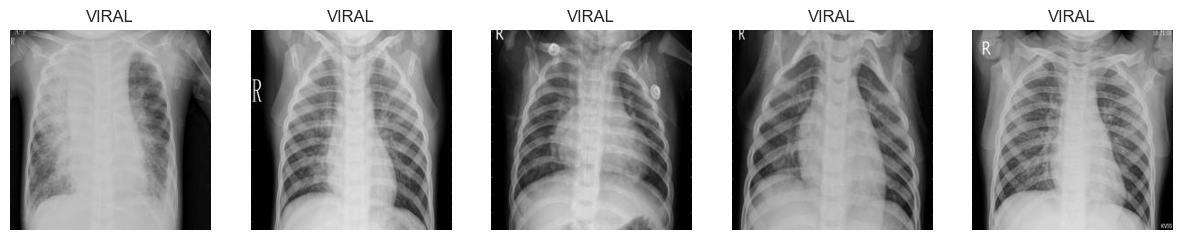

In [15]:
def show_random_images(df, label, num_images=5):
    subset = df[df['label'] == label].sample(n=num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for img_path, ax in zip(subset['path'], axes):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(label)
    plt.show()

for lbl in df['label'].unique():
    show_random_images(df, lbl)

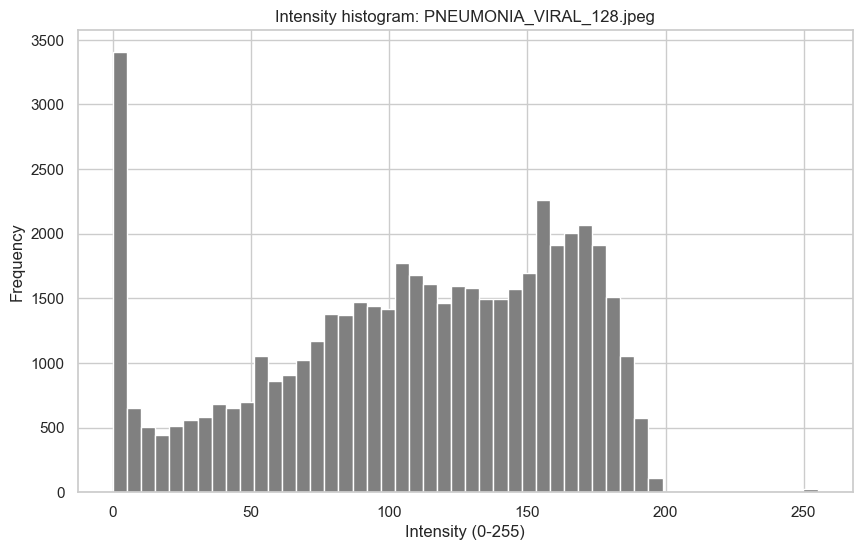

In [25]:
def plot_intensity_histogram(img_path):
    img = Image.open(img_path).convert('L')
    pixels = list(img.getdata())
    plt.hist(pixels, bins=50, color='gray')
    plt.title(f"Intensity histogram: {os.path.basename(img_path)}")
    plt.xlabel("Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.show()

sample_path = random.choice(df['path'].tolist())
plot_intensity_histogram(sample_path)
